# Earthquake Analysis

In this notebook I explore earthquake data from the [USGS website](https://earthquake.usgs.gov/earthquakes/search/) in response (originally) to the [series of earthquakes](https://twitter.com/snowjake/status/966139333093675008) in the Diablo, CA area in February 2018.


`query3.csv` was pulled at 7:35pm PT on Tuesday, February 23, and includes data for all earthquakes since 1975 within the following coordinates (it's a box surrounding Diablo, CA):
>Rectange:

>    [37.809, 37.868] Latitude

>    [-122.003, -121.922] Longitude

`query3.csv` was pulled at 9:35pm PT on Tuesday, February 27, and includes data for all earthquakes since 1975 within the same Diablo, CA coordinates.

`query4.csv` includes data for all earthquakes since 2000 within the following coordinates (box surrounding San Francisco Bay Area):

>Rectange:

>    [37.272, 38.05] Lattitude
   
>    [-122.753,-121.786] Longitude

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from calendar import monthrange, month_name

df=pd.read_csv("query4.csv")
OUTPUT_CHARTS = False # Set to True to output PNGs for all charts

In [2]:
# Convert time to datetime format
df["time"] = df["time"].astype("datetime64[ns]")

In [3]:
# Add columns to dataframe to allow further analysis

df["year"] = df["time"].dt.year
df["month"] = df["time"].dt.month
df["day"] = df["time"].dt.day
df["hour"] = df["time"].dt.hour
df["monthyear"] = df["time"].dt.strftime("%Y%m")

In [4]:
# The next line sets the number of rows displayed when data is referenced without a limitation (e.g., `head()` or `tail()`)
# pd.options.display.max_rows = 500

# Confirm that the dataframe is constructed properly
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,magError,magNst,status,locationSource,magSource,year,month,day,hour,monthyear
0,2018-02-27 23:10:31.840,37.836500,-121.983333,6.18,2.02,md,57.0,54.0,0.02706,0.11,...,0.190,41.0,reviewed,nc,nc,2018,2,27,23,201802
1,2018-02-27 19:41:45.340,37.834667,-121.975000,5.53,1.51,md,19.0,68.0,0.02047,0.10,...,0.162,14.0,reviewed,nc,nc,2018,2,27,19,201802
2,2018-02-27 03:29:03.710,37.682335,-122.509666,11.74,2.03,md,33.0,97.0,0.05287,0.04,...,0.180,25.0,automatic,nc,nc,2018,2,27,3,201802
3,2018-02-27 02:57:34.480,37.841500,-121.973833,6.22,1.21,md,21.0,59.0,0.02042,0.08,...,0.185,14.0,reviewed,nc,nc,2018,2,27,2,201802
4,2018-02-27 01:07:03.920,37.832500,-121.979667,6.04,1.34,md,18.0,69.0,0.02433,0.07,...,0.150,10.0,reviewed,nc,nc,2018,2,27,1,201802


In [5]:
def filter_by_magnitude(df, mag):
    """
    Return dataframe filtered by magnitude (i.e., only including 
    earthquakes with magnitude greater than mag).
    """
    df_copy = df.copy() # Copy dataframe to avoid adding column to original
    df_copy["over2.5"] = [x>mag for x in df["mag"]]
    df_filtered = df_copy[(df_copy['over2.5'] == True)]
    return df_filtered

In [6]:
df_bigger = filter_by_magnitude(df, 2.5)
df_bigger.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,magNst,status,locationSource,magSource,year,month,day,hour,monthyear,over2.5
25,2018-02-23 20:21:59.300,37.829167,-121.979333,6.79,2.80,md,111.0,41.0,0.02242,0.13,...,79.0,reviewed,nc,nc,2018,2,23,20,201802,True
26,2018-02-23 20:19:39.660,37.826333,-121.984500,6.16,3.51,mw,137.0,25.0,0.01812,0.18,...,3.0,reviewed,nc,nc,2018,2,23,20,201802,True
27,2018-02-23 20:19:24.790,37.828500,-121.981833,5.98,3.39,mw,103.0,40.0,0.02094,0.16,...,3.0,reviewed,nc,nc,2018,2,23,20,201802,True
35,2018-02-23 13:28:40.520,37.825667,-121.979333,6.93,3.31,mw,148.0,34.0,0.01943,0.20,...,4.0,reviewed,nc,nc,2018,2,23,13,201802,True
40,2018-02-23 11:24:57.300,37.831500,-121.979000,5.95,2.81,md,105.0,45.0,0.02396,0.14,...,71.0,reviewed,nc,nc,2018,2,23,11,201802,True


# Functions

Let's load some functions so we can dig into the data. We want these to operate on the earthquake dataframes so we can apply them to filtered or expanded data sets.

In [7]:
def count_monthyear(df):
    """Return array of earthquake counts by month and year for input dataframe."""
    histo = df["time"].groupby([df["year"], df["month"]]).agg("count")
    return histo

In [8]:
def np_to_tuples(count_array, final_length):
    """Returns a list of tuples of lenth final_length with zeros filled in where no corresponding
    entry exists in the input array."""
    day_list = []
    for i in range(1,final_length+1):
        day_list.append((i,0))
        for index,x in np.ndenumerate(count_array.index):
            if i == x:
                day_list[-1] = (i,count_array.data[index[0]])
                break
    return day_list

In [9]:
def plot_all_months(df):
    """
    Display a histogram plot of earthquakes per month for each month in the input dataframe.
    Note that months with zero earthquakes are omitted, so the x axis should not be considered
    a scale measure of time.
    """
    histogram = count_monthyear(df)
    plt.figure(num=None, figsize=(10, 4), dpi=160, facecolor='w', edgecolor='k')
    plt.title("Earthquakes by Month")
    n = 12
    ax_month = histogram.plot(kind='bar', rot=60, position=0.5, width=.85)
    ticks = ax_month.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax_month.xaxis.get_ticklabels()]
    ax_month.xaxis.set_ticks(ticks[::n])
    ax_month.xaxis.set_ticklabels(ticklabels[::n])
    plt.tight_layout()
    if OUTPUT_CHARTS: plt.savefig("quakes_by_month.png")

In [10]:
def plot_hourly(df):
    """Display a histogram plot of earthquakes per by hour of the day in the input dataframe."""
    plt.figure(num=None, figsize=(4, 3), dpi=160, facecolor='w', edgecolor='k')
    hourly = df["time"].groupby(df["hour"]).agg("count")
    hourly.plot(kind='bar')
    plt.title("Earthquakes by Hour")
    if OUTPUT_CHARTS: plt.savefig("quakes_by_hour.png")

In [11]:
def month_by_day(df, month, year):
    """Return a filtered dataframe including only earthquakes in a given month and year."""
    filtered = df[(df.monthyear == str(year)+str(month).zfill(2))]
    by_day = filtered["time"].groupby(filtered["day"]).agg("count")
    days_in_month = monthrange(year, month)[1]
    day_data = np_to_tuples(by_day,days_in_month)
    month_df = pd.DataFrame(day_data, columns=('Day', 'Quakes'))
    return month_df

In [12]:
def plot_month(df, month, year):
    """Display a histogram plot of earthquakes in the given month and year of the input dataframe."""
    plt.figure(num=None, figsize=(4, 3), dpi=100, facecolor='w', edgecolor='k')
    plt.title(f'Earthquakes in {month_name[month]} {year} by Day')
    new_df = month_by_day(df,month,year)
    days_in_month = monthrange(year, month)[1]
    ax = new_df.Quakes.plot(x='Day', kind='bar', rot=0, figsize=(8,5))
    ax.set_xticklabels(new_df.Day)
    if OUTPUT_CHARTS: plt.savefig(f"quakes_{month_name[month]}_{year}.png")

In [13]:
def plot_all_years(df):
    """Display a histogram plot of earthquakes per year for each year in the input dataframe."""
    # Make array for histogram of years
    years_histo = df["time"].groupby([df["year"]]).agg("count")
    plt.figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
    plt.title("Earthquakes by Year")
    years_histo.plot(kind='bar')
    plt.tight_layout()
    if OUTPUT_CHARTS: plt.savefig("quakes_by_year.png")

In [14]:
def year_by_month(df, year):
    """Return a filtered dataframe including only earthquakes in a given year."""
    filtered = df[(df.year == year)]
    by_month = filtered["time"].groupby(filtered["month"]).agg("count")
    month_data = np_to_tuples(by_month,12)
    year_df = pd.DataFrame(month_data, columns=('Month', 'Quakes'))
    return year_df

In [15]:
def plot_year(df, year):
    """Display a histogram plot of earthquakes in the given year of the input dataframe."""
    plt.figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
    plt.title(f'Earthquakes in {year} by month')
    new_df = year_by_month(df, year)
    new_df['Monthname'] = [month_name[month] for month in new_df.Month]
    ax = new_df.Quakes.plot(kind='bar', rot=45, figsize=(8,5))
    ax.set_xticklabels(new_df.Monthname)
    if OUTPUT_CHARTS: plt.savefig(f"quakes_{year}.png")

In [16]:
def plot_magnitude_histogram(df, bins):
    plt.figure(num=None, figsize=(14, 6), dpi=100, facecolor='w', edgecolor='k')
    plt.title(f'Distribution of Earthquakes by Magnitude')
    df.mag.plot(kind="hist", bins=bins)
    if OUTPUT_CHARTS: plt.savefig("magnitude_distribution.png")

# Results

Ok! Now the charts.  First, the quakes per year in the data set.

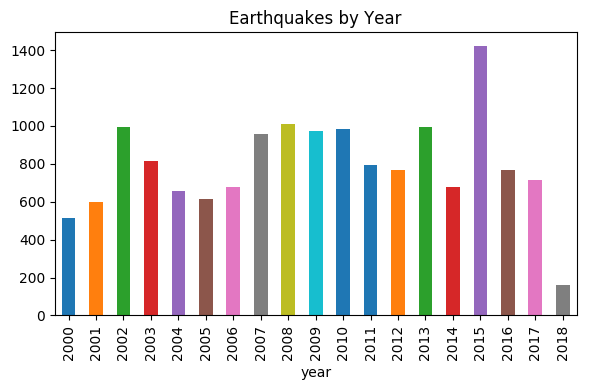

In [17]:
plot_all_years(df)

What about if we break it out even further, to see how many quakes there have been each month (with at least one quake).

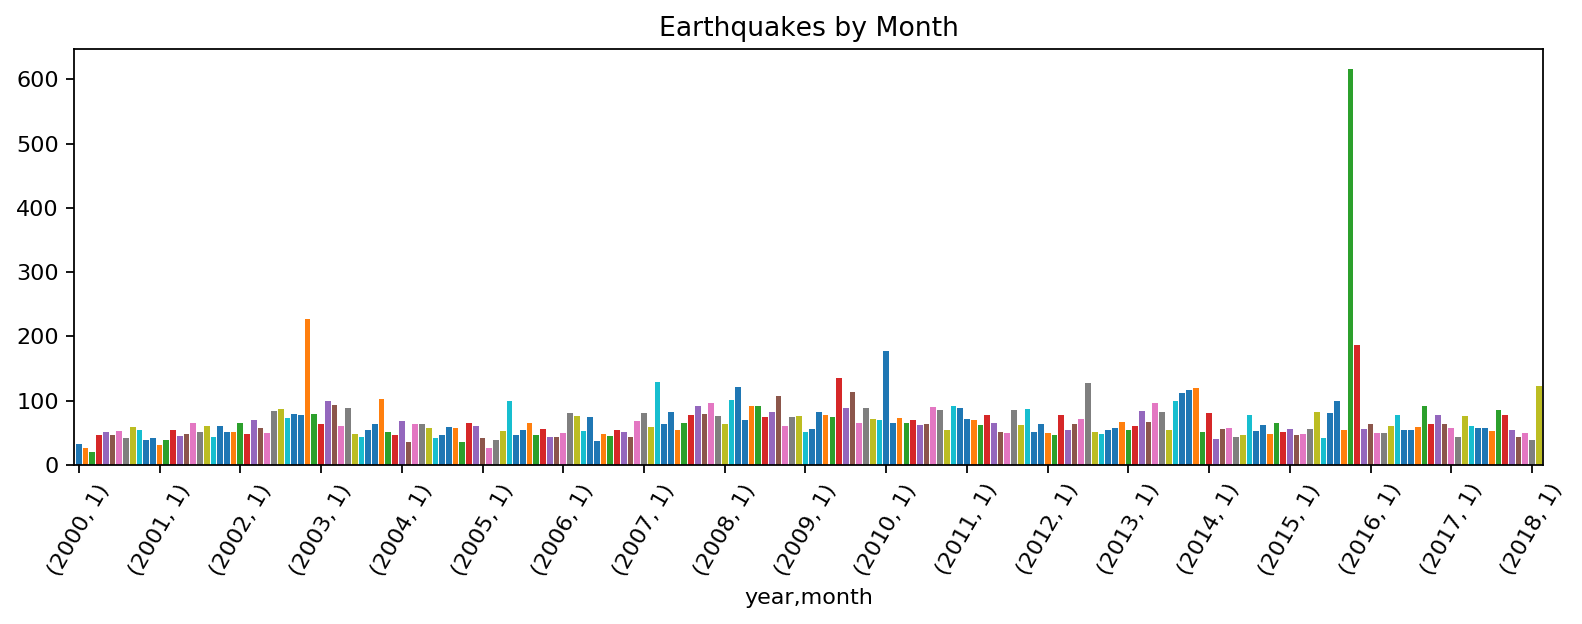

In [18]:
plot_all_months(df)

Do earthquakes happen more often at particular times of day in the input data?

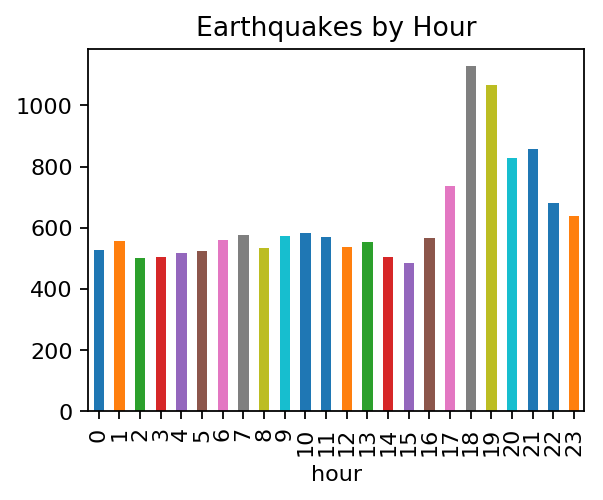

In [19]:
plot_hourly(df)

Let's drill down into a particular year and look at each month in that year.

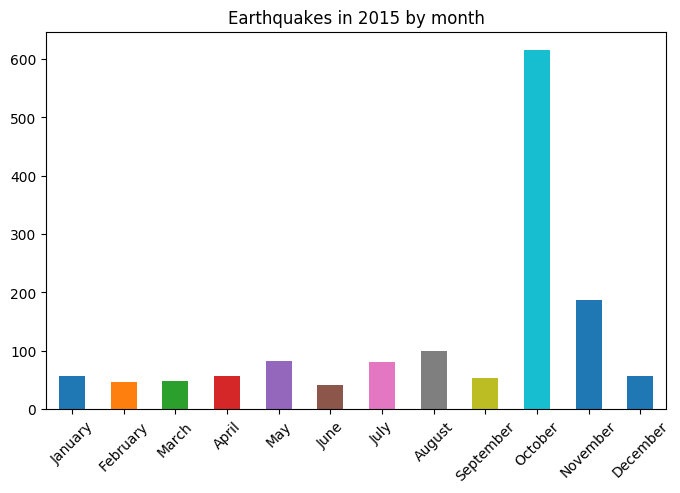

In [20]:
plot_year(df,2015)

And we can also look at a particular month to see earthquake activity per day.

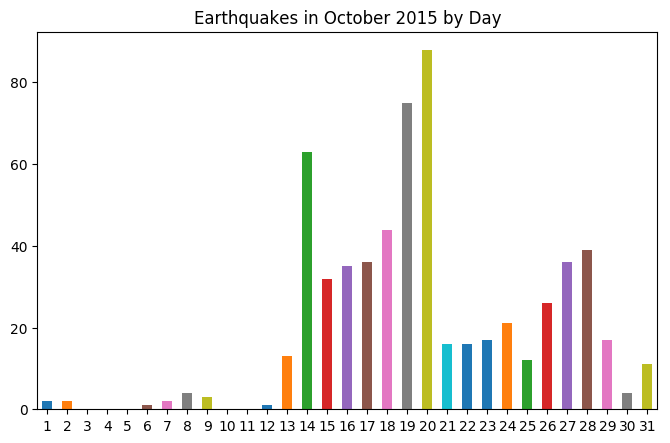

In [21]:
plot_month(df,10,2015)

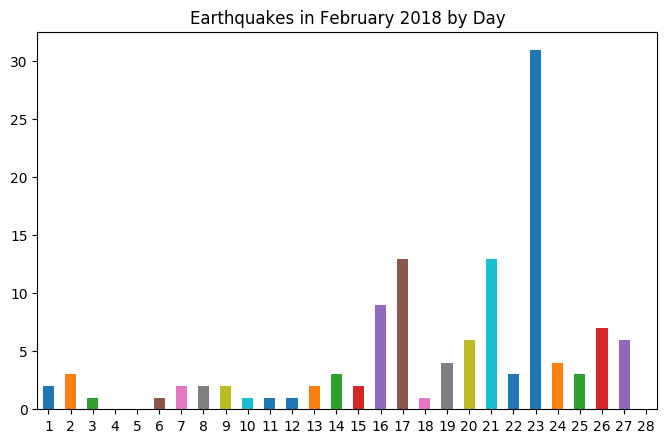

In [22]:
plot_month(df,2,2018)

Finally, let's look at the distribution of all the quakes by magnitude.

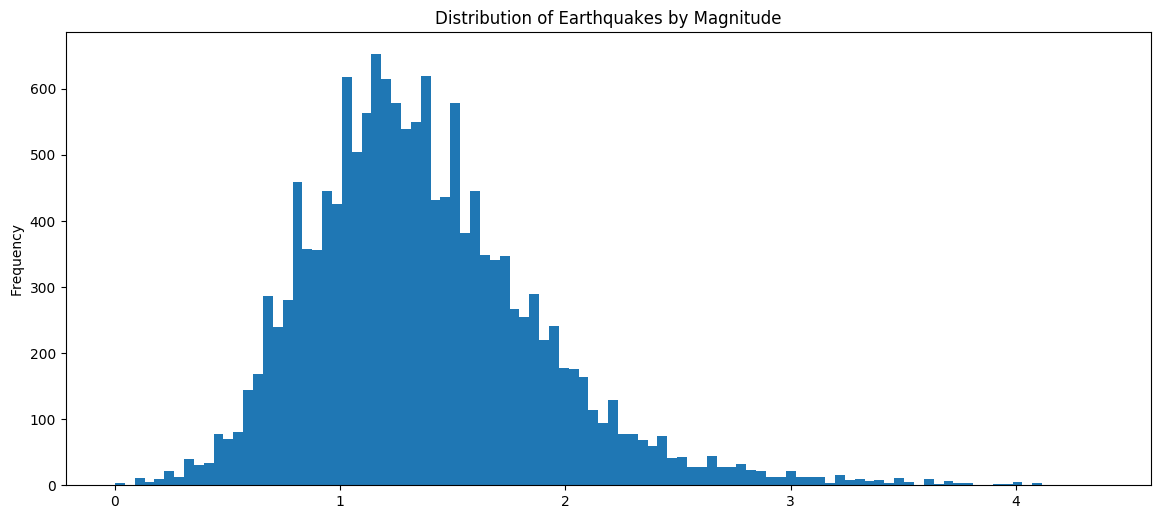

In [23]:
plot_magnitude_histogram(df, bins=100)

In [30]:
def scatterplot(x_data, y_data, x_label="", y_label="", title="", color = "r", yscale_log=False):

    # Create the plot object
    _, ax = plt.subplots(figsize=(10, 4), dpi=100)

   # Plot the data, set the size (s), color and transparency (alpha)
    # of the points
    ax.scatter(x_data, y_data, s = 0.05, color = color, alpha = 0.75)

    if yscale_log == True:
        ax.set_yscale('log')

    # Label the axes and provide a title
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

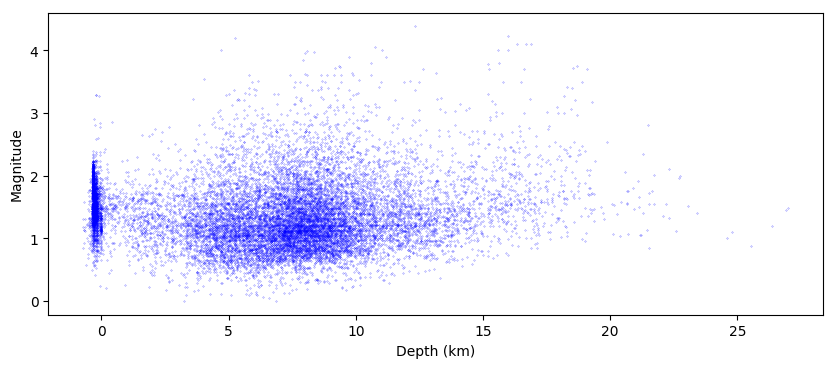

In [31]:
scatterplot(df.depth,df.mag, "Depth (km)","Magnitude",color='b')